<a href="https://colab.research.google.com/github/Best-Verie/waste_classification_ML/blob/main/waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kagglehub

import os, json, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from PIL import Image
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

np.random.seed(42)
tf.random.set_seed(42)
print(f"TensorFlow: {tf.__version__} | GPU: {tf.config.list_physical_devices('GPU')}")

TensorFlow: 2.19.0 | GPU: []


In [ ]:
import kagglehub
path = kagglehub.dataset_download("mostafaabla/garbage-classification")
print(f"Downloaded to: {path}")

Using Colab cache for faster access to the 'garbage-classification' dataset.
Downloaded to: /kaggle/input/garbage-classification


In [ ]:
# Find data directory
for root, dirs, files in os.walk(path):
    if len(dirs) >= 10:
        DATA_DIR = root
        break

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
class_counts = {name: len(os.listdir(os.path.join(DATA_DIR, name))) for name in class_names}

print(f"Data directory: {DATA_DIR}")
print(f"Classes ({len(class_names)}): {class_names}")
print(f"Total images: {sum(class_counts.values()):,}")

Data directory: /kaggle/input/garbage-classification/garbage_classification
Classes (12): ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Total images: 15,515


In [ ]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', seed=42
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', seed=42, shuffle=False
)

# Class mapping
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Save class mapping
os.makedirs('models', exist_ok=True)
with open('models/class_mapping.json', 'w') as f:
    json.dump({'class_indices': class_indices, 'idx_to_class': {str(k): v for k, v in idx_to_class.items()}}, f)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Training samples: 12415
Validation samples: 3100


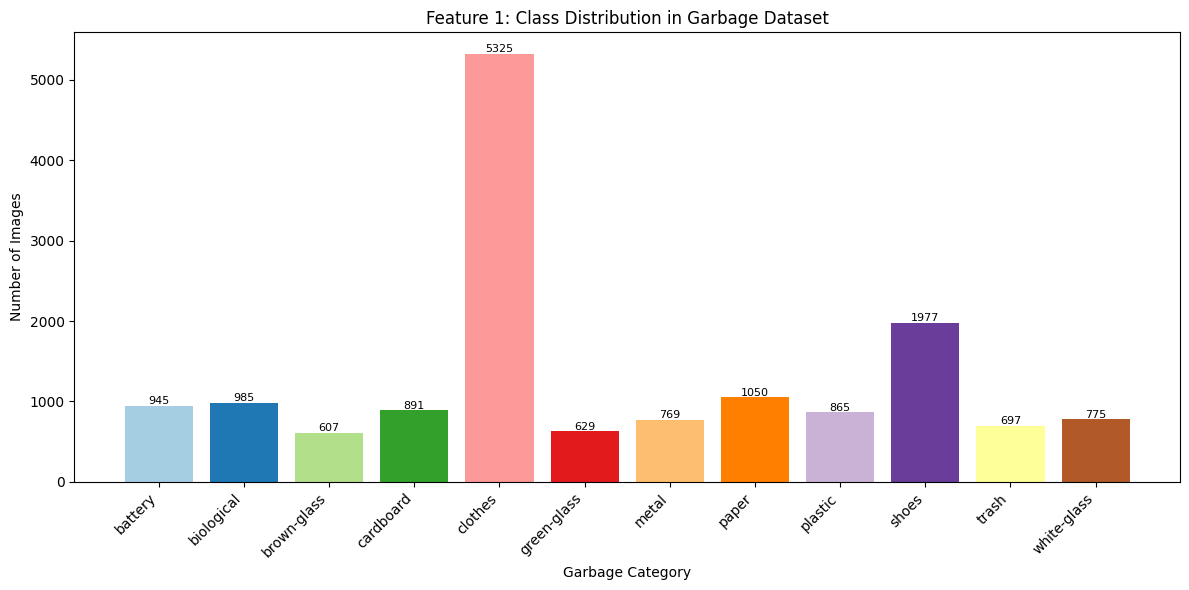


 Interpretation: Dataset contains 12 waste categories.
   Largest class: clothes (5325 images)
   Smallest class: brown-glass (607 images)
   This distribution helps identify potential class imbalance for model training.


In [ ]:
# FEATURE 1: Class Distribution
plt.figure(figsize=(12, 6))
colors = plt.cm.Paired(np.linspace(0, 1, len(class_counts)))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Garbage Category')
plt.ylabel('Number of Images')
plt.title('Feature 1: Class Distribution in Garbage Dataset')
plt.xticks(rotation=45, ha='right')
for bar, count in zip(bars, class_counts.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, str(count), ha='center', fontsize=8)
plt.tight_layout()
plt.savefig('models/viz1_class_distribution.png')
plt.show()

print(f"\n Interpretation: Dataset contains {len(class_names)} waste categories.")
print(f"   Largest class: {max(class_counts, key=class_counts.get)} ({max(class_counts.values())} images)")
print(f"   Smallest class: {min(class_counts, key=class_counts.get)} ({min(class_counts.values())} images)")
print(f"   This distribution helps identify potential class imbalance for model training.")

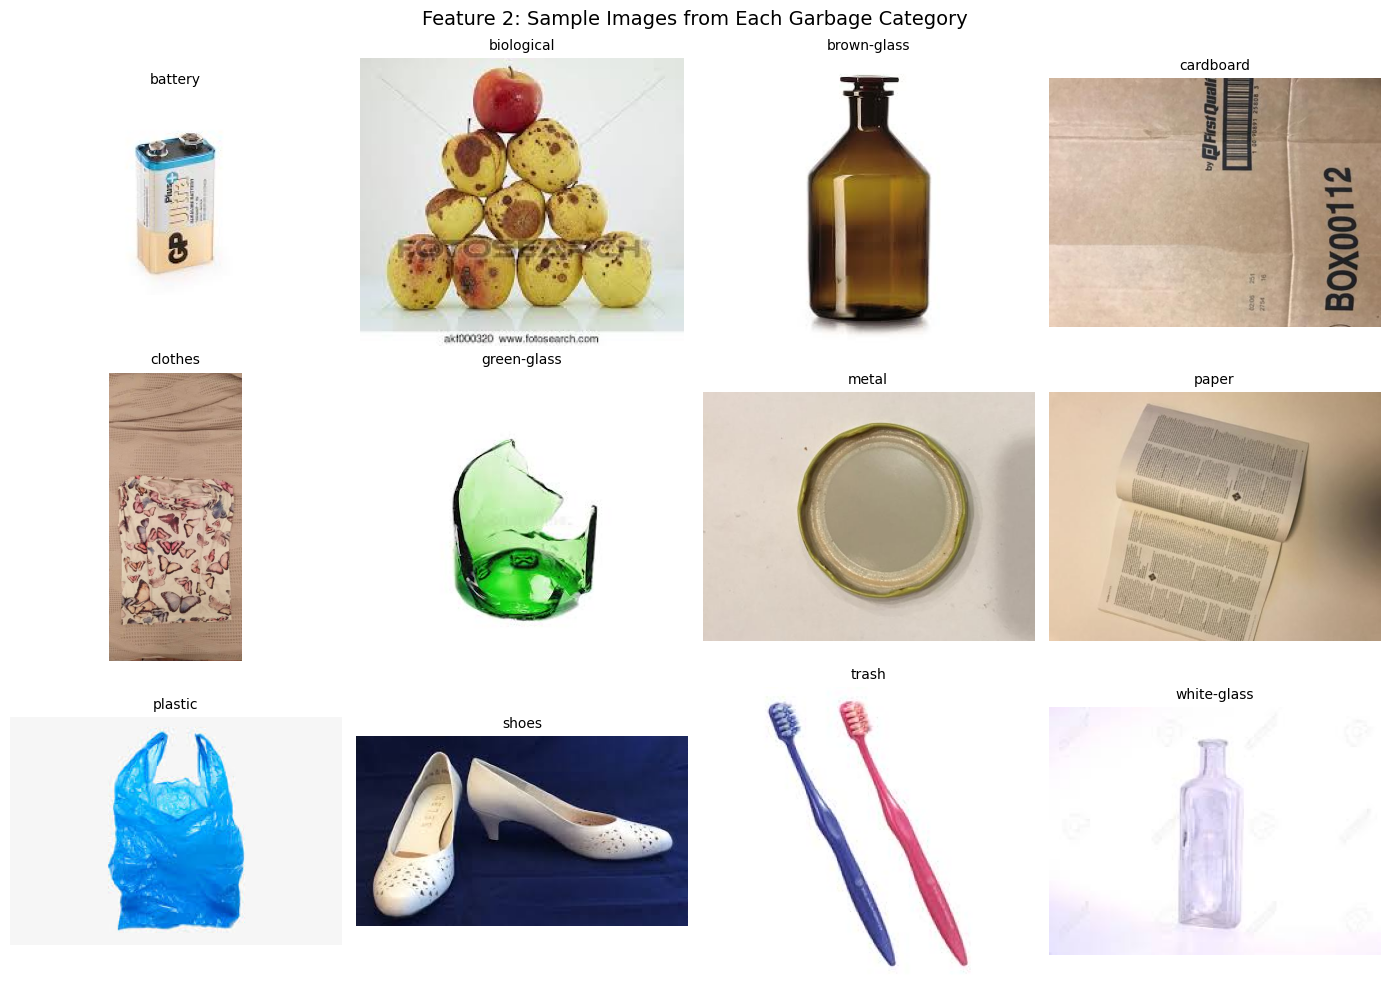


 Interpretation: Visual differences between categories:
   - Glass categories (brown, green, white) differ mainly in color
   - Organic items (biological) have irregular shapes and textures
   - Recyclables (cardboard, paper, metal) have distinct material properties
   - These visual features help CNN learn discriminative patterns.


In [ ]:
# FEATURE 2: Sample Images per Category
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.flatten()

for idx, class_name in enumerate(class_names[:12]):
    class_path = os.path.join(DATA_DIR, class_name)
    img_file = os.listdir(class_path)[0]
    img = Image.open(os.path.join(class_path, img_file))
    axes[idx].imshow(img)
    axes[idx].set_title(class_name, fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Feature 2: Sample Images from Each Garbage Category', fontsize=14)
plt.tight_layout()
plt.savefig('models/viz2_sample_images.png')
plt.show()

print("\n Interpretation: Visual differences between categories:")
print("   - Glass categories (brown, green, white) differ mainly in color")
print("   - Organic items (biological) have irregular shapes and textures")
print("   - Recyclables (cardboard, paper, metal) have distinct material properties")
print("   - These visual features help CNN learn discriminative patterns.")

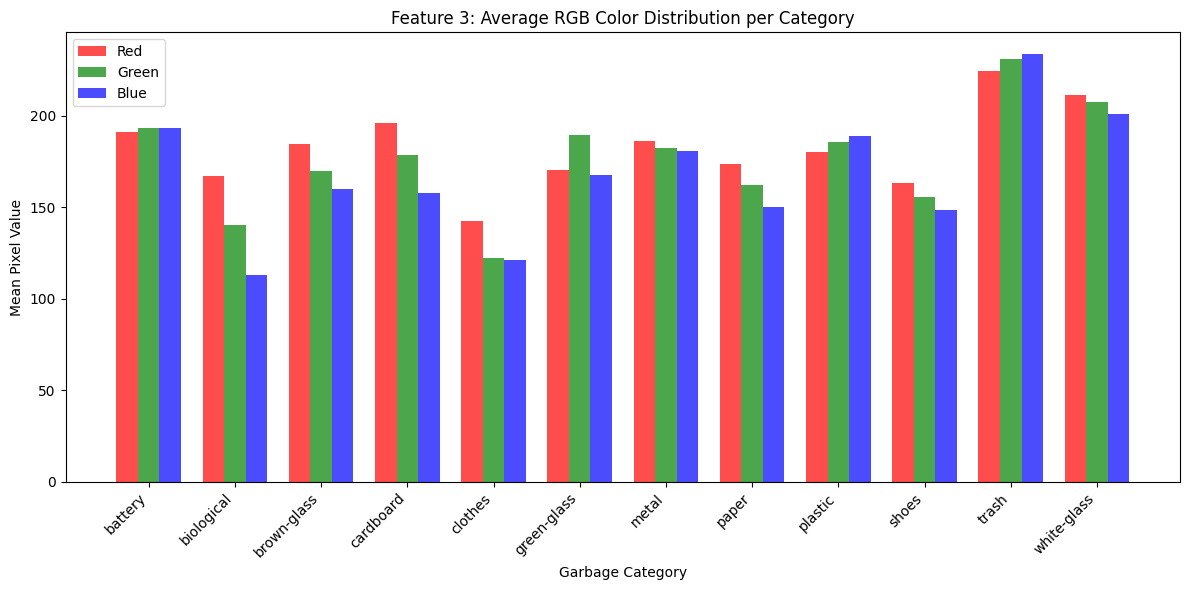


 Interpretation: Color patterns reveal material characteristics:
   - Brown/green glass shows distinct color dominance
   - Paper and cardboard have similar beige/brown tones
   - Metal items tend to have higher brightness (higher RGB values)
   - These color features serve as discriminative signals for classification.


In [ ]:
# FEATURE 3: Average Color Analysis per Category
color_stats = {}
for class_name in class_names:
    class_path = os.path.join(DATA_DIR, class_name)
    r_vals, g_vals, b_vals = [], [], []
    for img_file in os.listdir(class_path)[:30]:  # Sample 30 images
        try:
            img = np.array(Image.open(os.path.join(class_path, img_file)).convert('RGB'))
            r_vals.append(np.mean(img[:,:,0]))
            g_vals.append(np.mean(img[:,:,1]))
            b_vals.append(np.mean(img[:,:,2]))
        except: pass
    color_stats[class_name] = {'R': np.mean(r_vals), 'G': np.mean(g_vals), 'B': np.mean(b_vals)}

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

r_means = [color_stats[c]['R'] for c in class_names]
g_means = [color_stats[c]['G'] for c in class_names]
b_means = [color_stats[c]['B'] for c in class_names]

ax.bar(x - width, r_means, width, label='Red', color='red', alpha=0.7)
ax.bar(x, g_means, width, label='Green', color='green', alpha=0.7)
ax.bar(x + width, b_means, width, label='Blue', color='blue', alpha=0.7)

ax.set_xlabel('Garbage Category')
ax.set_ylabel('Mean Pixel Value')
ax.set_title('Feature 3: Average RGB Color Distribution per Category')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig('models/viz3_color_analysis.png')
plt.show()

print("\n Interpretation: Color patterns reveal material characteristics:")
print("   - Brown/green glass shows distinct color dominance")
print("   - Paper and cardboard have similar beige/brown tones")
print("   - Metal items tend to have higher brightness (higher RGB values)")
print("   - These color features serve as discriminative signals for classification.")

In [ ]:
# MobileNetV2 Transfer Learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,004 (9.88 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('models/best_model.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# Train
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 928s 2s/step - accuracy: 0.7309 - loss: 0.8788 - val_accuracy: 0.8623 - val_loss: 0.3912 - learning_rate: 0.0010
Epoch 2/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 939s 2s/step - accuracy: 0.8787 - loss: 0.3749 - val_accuracy: 0.8587 - val_loss: 0.3873 - learning_rate: 0.0010
Epoch 3/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 901s 2s/step - accuracy: 0.8922 - loss: 0.3313 - val_accuracy: 0.8755 - val_loss: 0.3540 - learning_rate: 0.0010
Epoch 4/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 896s 2s/step - accuracy: 0.9021 - loss: 0.3013 - val_accuracy: 0.8858 - val_loss: 0.3329 - learning_rate: 0.0010
Epoch 5/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 926s 2s/step - accuracy: 0.9131 - loss: 0.2718 - val_accuracy: 0.8848 - val_loss: 0.3319 - learning_rate: 0.0010
Epoch 6/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 911s 2s/step - accuracy: 0.9128 - loss: 0.2511 - val_accuracy: 0.8855 - val_loss: 0.3315 - learning_rate: 0.0010
Epoch 7/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 910s 2s/step - accuracy: 0.9160 - loss: 0.

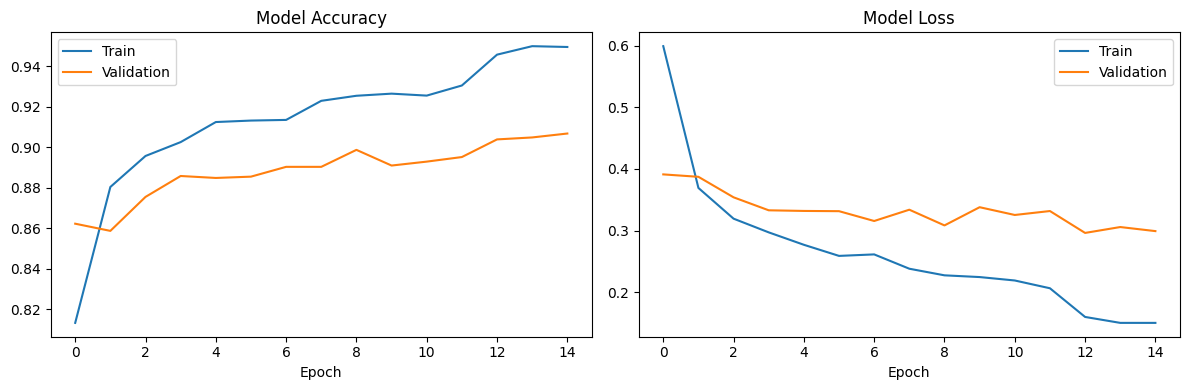

In [ ]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.tight_layout()
plt.savefig('models/training_history.png')
plt.show()

In [ ]:
# Load best model
best_model = tf.keras.models.load_model('models/best_model.keras')

# Predictions
val_generator.reset()
y_pred = np.argmax(best_model.predict(val_generator), axis=1)
y_true = val_generator.classes

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("="*50)
print("MODEL EVALUATION METRICS")
print("="*50)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Save metrics
with open('models/metrics.json', 'w') as f:
    json.dump({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}, f)

97/97 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step
MODEL EVALUATION METRICS
Accuracy:  0.9068 (90.68%)
Precision: 0.9110
Recall:    0.9068
F1-Score:  0.9065


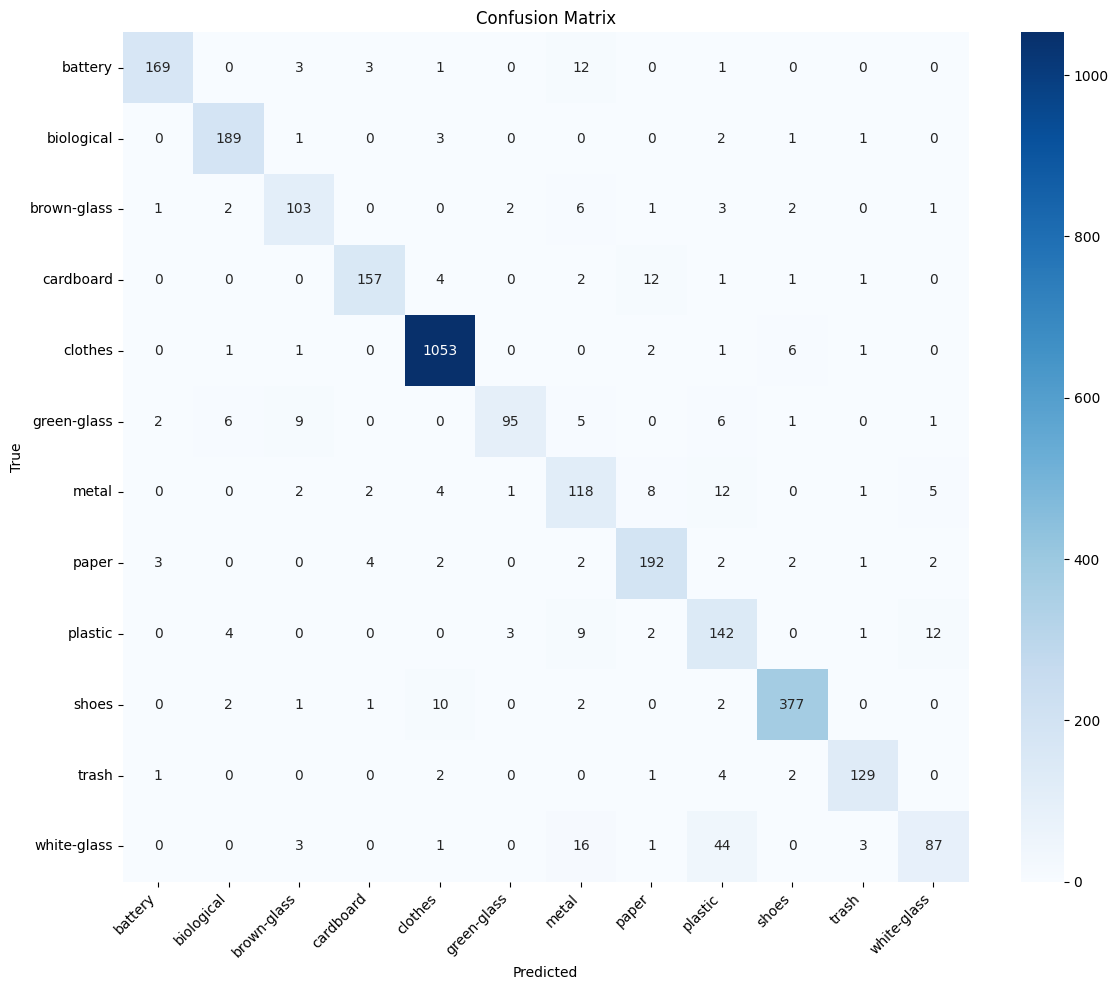

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('models/confusion_matrix.png')
plt.show()

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

     battery       0.96      0.89      0.93       189
  biological       0.93      0.96      0.94       197
 brown-glass       0.84      0.85      0.84       121
   cardboard       0.94      0.88      0.91       178
     clothes       0.97      0.99      0.98      1065
 green-glass       0.94      0.76      0.84       125
       metal       0.69      0.77      0.73       153
       paper       0.88      0.91      0.90       210
     plastic       0.65      0.82      0.72       173
       shoes       0.96      0.95      0.96       395
       trash       0.93      0.93      0.93       139
 white-glass       0.81      0.56      0.66       155

    accuracy                           0.91      3100
   macro avg       0.87      0.86      0.86      3100
weighted avg       0.91      0.91      0.91      3100



In [ ]:
def predict_image(image_path, model, idx_to_class):
    """
    Predict garbage category from image.

    Args:
        image_path: Path to image file
        model: Trained model
        idx_to_class: Index to class mapping

    Returns:
        Dictionary with prediction and confidence
    """
    img = Image.open(image_path).convert('RGB').resize((224, 224))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

    preds = model.predict(img_array, verbose=0)[0]
    top_idx = np.argsort(preds)[-5:][::-1]

    return {
        'prediction': idx_to_class[top_idx[0]],
        'confidence': float(preds[top_idx[0]]),
        'top_5': [{'class': idx_to_class[i], 'confidence': float(preds[i])} for i in top_idx]
    }

In [ ]:
# Test predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, class_name in enumerate(class_names[:8]):
    class_path = os.path.join(DATA_DIR, class_name)
    img_file = os.listdir(class_path)[5]  # Pick 5th image
    img_path = os.path.join(class_path, img_file)

    result = predict_image(img_path, best_model, idx_to_class)

    img = Image.open(img_path)
    axes[idx].imshow(img)
    color = 'green' if result['prediction'] == class_name else 'red'
    axes[idx].set_title(f"True: {class_name}\nPred: {result['prediction']}\nConf: {result['confidence']:.2%}",
                        fontsize=9, color=color)
    axes[idx].axis('off')

plt.suptitle('Model Predictions on Test Images', fontsize=14)
plt.tight_layout()
plt.savefig('models/sample_predictions.png')
plt.show()

In [ ]:
def trigger_retraining(new_data_dir, model_path='models/best_model.keras', epochs=5):
    """
    Retrain model with new data.

    Args:
        new_data_dir: Directory with new training data (organized by class folders)
        model_path: Path to existing model
        epochs: Number of training epochs

    Returns:
        Dictionary with training results
    """
    try:
        # Load existing model
        model = tf.keras.models.load_model(model_path)

        # Prepare new data
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            horizontal_flip=True,
            validation_split=0.2
        )

        train_gen = datagen.flow_from_directory(
            new_data_dir, target_size=(224, 224), batch_size=32, subset='training'
        )
        val_gen = datagen.flow_from_directory(
            new_data_dir, target_size=(224, 224), batch_size=32, subset='validation'
        )

        # Compile with low learning rate for fine-tuning
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Retrain
        history = model.fit(
            train_gen, epochs=epochs, validation_data=val_gen,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
        )

        # Save updated model
        model.save(model_path)

        return {
            'success': True,
            'message': 'Model retrained successfully',
            'final_accuracy': float(history.history['val_accuracy'][-1]),
            'epochs_trained': len(history.history['accuracy'])
        }

    except Exception as e:
        return {'success': False, 'error': str(e)}

print(" Retraining function defined.")
print("Usage: trigger_retraining('/path/to/new_data', epochs=5)")

In [ ]:
# Save in multiple formats
best_model.save('models/garbage_classifier.h5')
best_model.save('models/garbage_classifier.keras')

print("\n Models saved:")
print("   - models/best_model.keras")
print("   - models/garbage_classifier.h5")
print("   - models/garbage_classifier.keras")
print("   - models/class_mapping.json")
print("   - models/metrics.json")

In [ ]:
# Download models (for Colab)
import shutil
shutil.make_archive('garbage_models', 'zip', 'models')

try:
    from google.colab import files
    files.download('garbage_models.zip')
except:
    print("Models saved in 'models/' directory")